In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
cd /content/gdrive/MyDrive/MedicalPaper

/content/gdrive/MyDrive/MedicalPaper


In [3]:
# Import the necessary library
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salmansajid05/oral-diseases")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/oral-diseases


In [5]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3"

for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files[:5]}")  # Show first 5 files in each directory
    print("-" * 50)

# Asli-Always work

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the original directories and their corresponding class names
original_dirs = {
    'Caries': '/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview',
    'Gingivitis': '/kaggle/input/oral-diseases/Gingivitis/Gingivitis',
    'Ulcers': '/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
    'Tooth Discoloration': '/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview',
    'Hypodontia': '/kaggle/input/oral-diseases/hypodontia/hypodontia'
}

# Define the target base directory
base_dir = '/kaggle/working/dataset'

# Define the target structure
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

# Create target directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to copy images to the target directory and count them
def copy_and_count_images(class_name, image_paths):
    if not image_paths:
        print(f"No images found for class: {class_name}")
        return

    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 0.2 * 0.9 = 0.18

    # Check for empty splits
    if not train_paths or not val_paths or not test_paths:
        print(f"Warning: Empty split for {class_name}")
        return

    # Define split mappings
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Copy images to their respective directories and count them
    for split, paths in split_paths.items():
        class_split_counts[class_name][split] = len(paths)
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

# Traverse the original directories and gather image paths
for class_name, original_dir in original_dirs.items():
    if not os.path.exists(original_dir):
        print(f"Skipping {class_name}: Directory not found - {original_dir}")
        continue

    image_paths = []
    for root, dirs, files in os.walk(original_dir):
        image_paths.extend([os.path.join(root, file) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))])

    print(f"{class_name}: Found {len(image_paths)} images.")
    if image_paths:
        copy_and_count_images(class_name, image_paths)

print("\nImages have been copied and organized successfully.")
print("\nNumber of images per class:")
for class_name, counts in class_split_counts.items():
    print(f"\n{class_name}:")
    print(f"  Train: {counts['train']}")
    print(f"  Val:   {counts['val']}")
    print(f"  Test:  {counts['test']}")


Caries: Found 2382 images.
Gingivitis: Found 2340 images.
Ulcers: Found 2541 images.
Tooth Discoloration: Found 1834 images.
Hypodontia: Found 342 images.

Images have been copied and organized successfully.

Number of images per class:

Caries:
  Train: 1714
  Val:   429
  Test:  239

Gingivitis:
  Train: 1684
  Val:   422
  Test:  234

Ulcers:
  Train: 1828
  Val:   458
  Test:  255

Tooth Discoloration:
  Train: 1320
  Val:   330
  Test:  184

Hypodontia:
  Train: 245
  Val:   62
  Test:  35


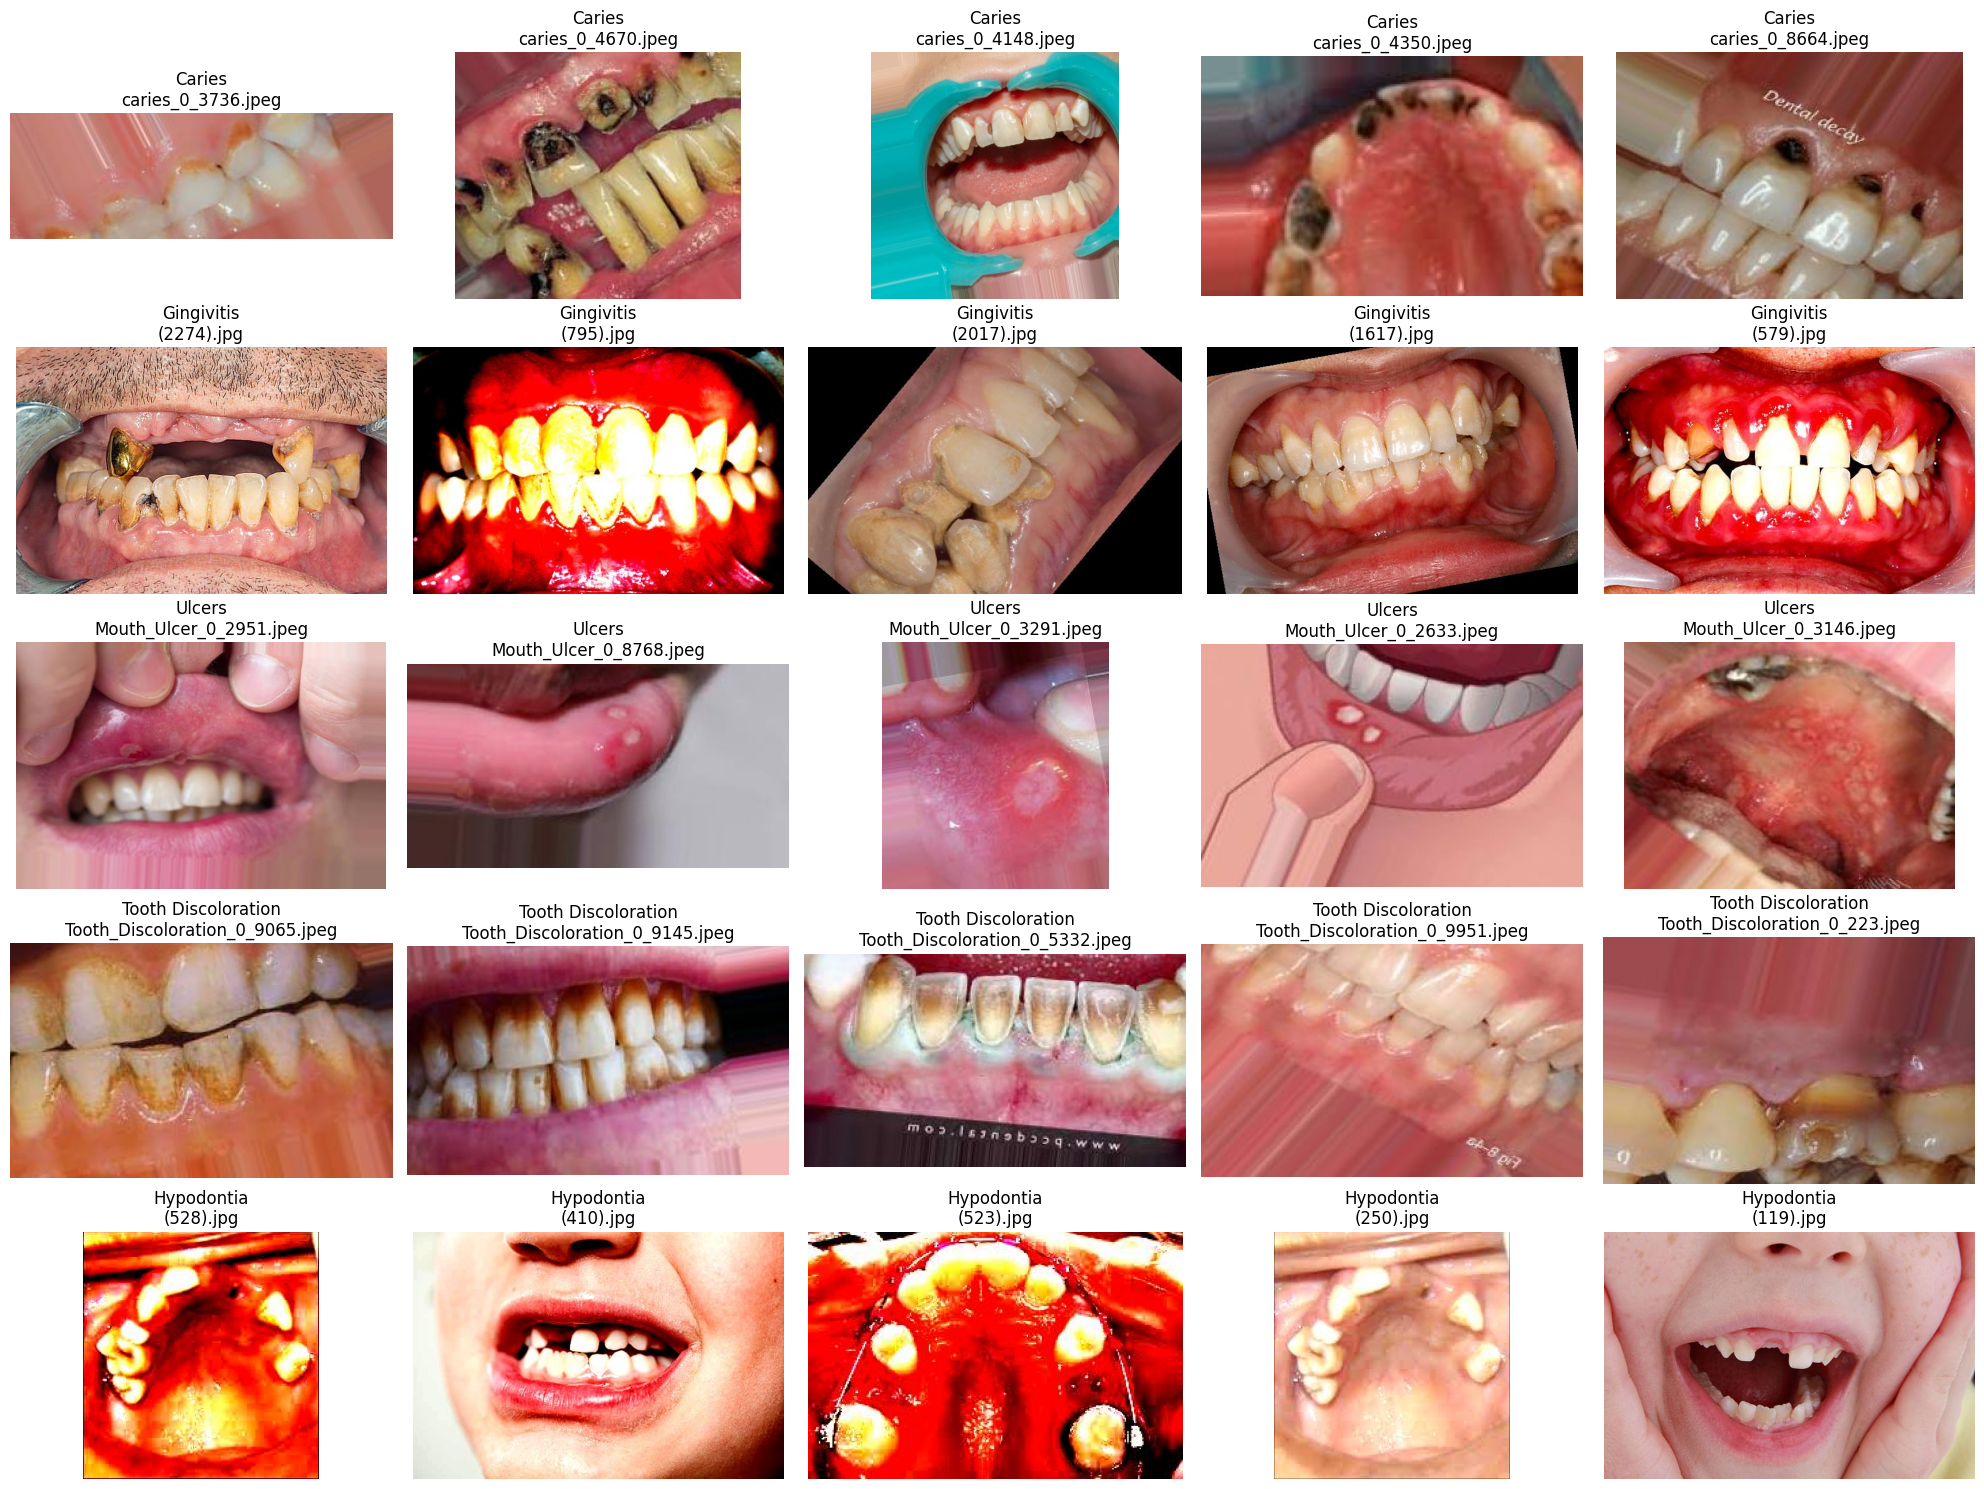

In [7]:
import matplotlib.pyplot as plt
import os

# Define the base directory where the dataset is organized
base_dir = '/kaggle/working/dataset'

# Define the classes
classes = [ 'Caries', 'Gingivitis', 'Ulcers', 'Tooth Discoloration', 'Hypodontia']

# Set up the plot
plt.figure(figsize=(20, 15))
num_samples = 5  # Number of images to display per class

# Loop through each class and display 5 images
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, 'train', class_name)  # Use the 'train' split
    image_files = os.listdir(class_path)[:num_samples]  # Get the first 5 images

    for img_idx, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)

        # Plot the image
        plt.subplot(len(classes), num_samples, class_idx * num_samples + img_idx + 1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img_file}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Number of images per class:

Caries:
  Train: 1714
  Val:   429
  Test:  239

Gingivitis:
  Train: 1684
  Val:   422
  Test:  234

Ulcers:
  Train: 1828
  Val:   458
  Test:  255

Tooth Discoloration:
  Train: 1320
  Val:   330
  Test:  184

Hypodontia:
  Train: 245
  Val:   62
  Test:  35


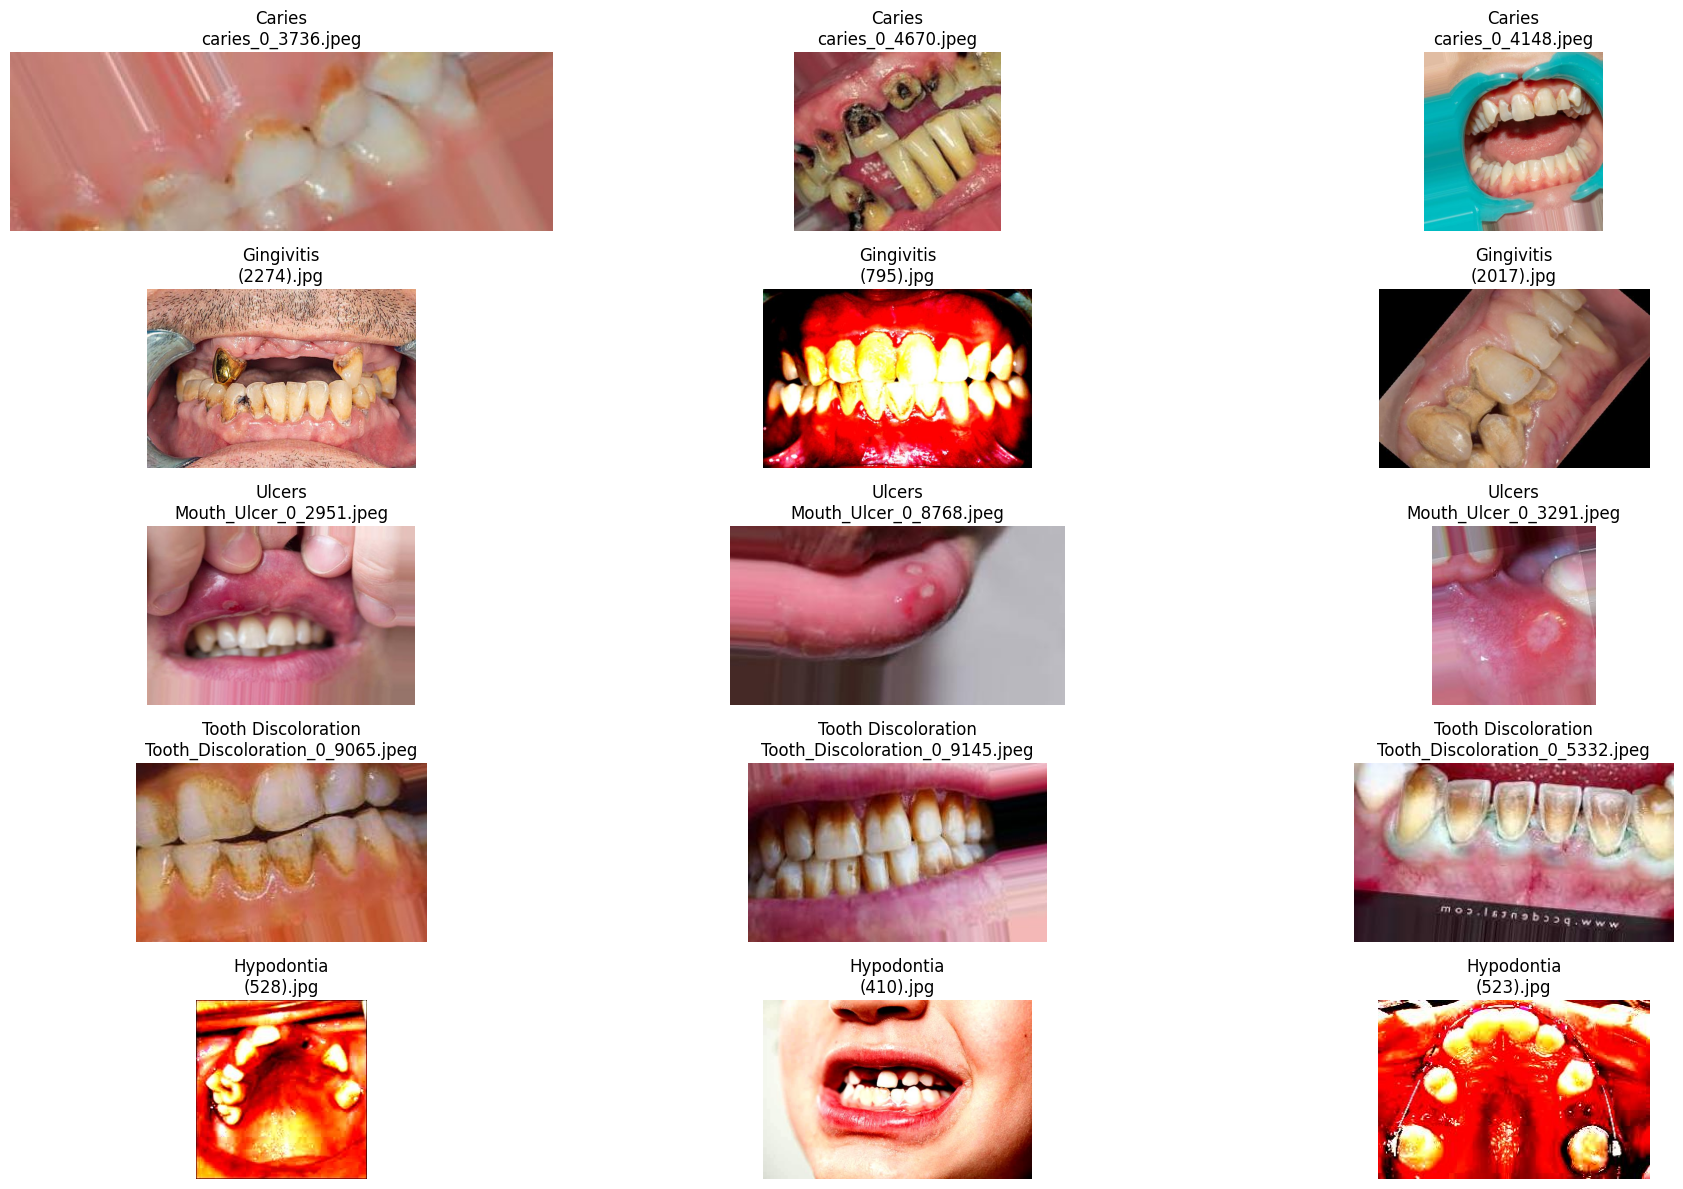

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Print the distribution of images per class and split
print("Number of images per class:")
for class_name, counts in class_split_counts.items():
    print(f"\n{class_name}:")
    print(f"  Train: {counts['train']}")
    print(f"  Val:   {counts['val']}")
    print(f"  Test:  {counts['test']}")

# Visualize sample images from each class
plt.figure(figsize=(20, 12))
splits_to_show = ['train', 'val', 'test']
num_samples = 3  # Number of samples to show per class

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, 'train', class_name)
    image_files = os.listdir(class_path)[:num_samples]  # Get first 3 images

    for img_idx, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(len(classes), num_samples, class_idx * num_samples + img_idx + 1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img_file}")
        plt.axis('off')

plt.tight_layout()
plt.show()

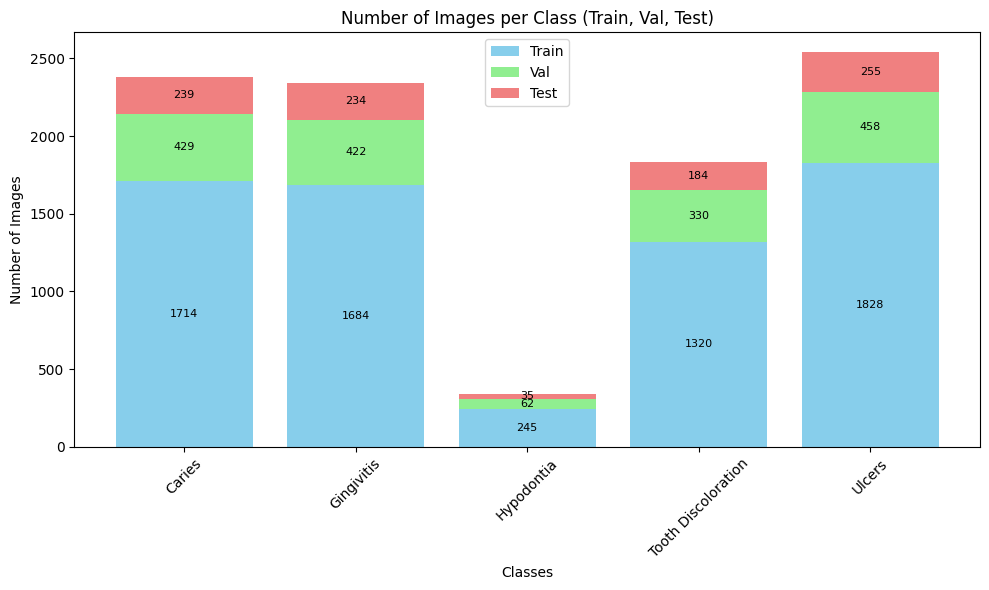

In [9]:
import os
import matplotlib.pyplot as plt

# Define class labels without 'Calculus'
classes = ['Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']

# Define base directory
base_dir = '/kaggle/working/dataset'  # Update this path

# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to count images in each split
def count_images(base_dir, class_name):
    counts = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        if os.path.exists(split_dir):  # Check if directory exists
            counts[split] = len(os.listdir(split_dir))
        else:
            counts[split] = 0
    return counts

# Calculate counts for each class and split
for class_name in classes:
    class_split_counts[class_name] = count_images(base_dir, class_name)

# Create lists for the bar plot
labels = classes
train_counts = [class_split_counts[class_name]['train'] for class_name in classes]
val_counts = [class_split_counts[class_name]['val'] for class_name in classes]
test_counts = [class_split_counts[class_name]['test'] for class_name in classes]

x = range(len(classes))

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x, train_counts, label='Train', color='skyblue')
bar2 = ax.bar(x, val_counts, bottom=train_counts, label='Val', color='lightgreen')
bar3 = ax.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)], label='Test', color='lightcoral')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (Train, Val, Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Add data labels with corrected positions
for bar in bar1:
    height = bar.get_height()
    if height > 0:  # Only label if height is greater than 0
        ax.text(bar.get_x() + bar.get_width()/2, height / 2, f'{int(height)}',
                ha='center', va='center', color='black', fontsize=8)

for bar in bar2:
    height = bar.get_height()
    if height > 0:
        y_pos = bar.get_y() + height / 2  # Middle of the current segment
        ax.text(bar.get_x() + bar.get_width()/2, y_pos, f'{int(height)}',
                ha='center', va='center', color='black', fontsize=8)

for bar in bar3:
    height = bar.get_height()
    if height > 0:
        y_pos = bar.get_y() + height / 2  # Middle of the current segment
        ax.text(bar.get_x() + bar.get_width()/2, y_pos, f'{int(height)}',
                ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
239+429+1714+234+422+1684+35+62+245+1320+330+184+1828+458+255

9439

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

# Define directories
base_dir = '/kaggle/working/dataset'  # Update this path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
image_size = (128, 128)
batch_size = 16
num_epochs = 10

# Define class labels without 'Calculus'
classes = ['Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Normalization for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Custom dataset class to exclude 
class MedicalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        self.classes = [cls for cls in os.listdir(data_dir) if cls != 'Calculus']
        self.classes = sorted(self.classes, key=lambda x: classes.index(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = self._make_dataset()

    def _make_dataset(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for img_name in os.listdir(cls_dir):
                samples.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load datasets using the custom MedicalDataset
train_dataset = MedicalDataset(train_dir, transform=train_transforms)
val_dataset = MedicalDataset(val_dir, transform=val_transforms)
test_dataset = MedicalDataset(test_dir, transform=val_transforms)

# Create data loaders with reduced num_workers
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
# Assuming train_loader, val_loader, and test_loader are already defined

# Extract classes from train_loader
train_classes = train_loader.dataset.classes
print("Classes in train_loader:", train_classes)

# Extract classes from val_loader
val_classes = val_loader.dataset.classes
print("Classes in val_loader:", val_classes)

# Extract classes from test_loader
test_classes = test_loader.dataset.classes
print("Classes in test_loader:", test_classes)

print('*'*50)


# Extract the number of samples from train_loader
num_train_samples = len(train_loader.dataset)

# Print the result
print("Number of training samples:", num_train_samples)

# Extract the number of samples from train_loader
num_val_samples = len(val_loader.dataset)

# Print the result
print("Number of validation samples:", num_val_samples)

# Extract the number of samples from train_loader
num_test_samples = len(test_loader.dataset)

# Print the result
print("Number of testing samples:", num_test_samples)

Classes in train_loader: ['Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']
Classes in val_loader: ['Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']
Classes in test_loader: ['Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']
**************************************************
Number of training samples: 6791
Number of validation samples: 1701
Number of testing samples: 947


In [13]:
6791+1701+947

9439

# Model

Epoch 01/50 | Train Loss: 0.1138 | Train Acc: 66.53% | Val Loss: 0.0316 | Val Acc: 88.42%
Validation loss decreased (inf --> 0.031629). Saving model...
Epoch 02/50 | Train Loss: 0.0423 | Train Acc: 84.83% | Val Loss: 0.0178 | Val Acc: 92.71%
Validation loss decreased (0.031629 --> 0.017759). Saving model...
Epoch 03/50 | Train Loss: 0.0235 | Train Acc: 90.77% | Val Loss: 0.0105 | Val Acc: 95.88%
Validation loss decreased (0.017759 --> 0.010463). Saving model...
Epoch 04/50 | Train Loss: 0.0175 | Train Acc: 93.65% | Val Loss: 0.0078 | Val Acc: 96.94%
Validation loss decreased (0.010463 --> 0.007790). Saving model...
Epoch 05/50 | Train Loss: 0.0121 | Train Acc: 95.48% | Val Loss: 0.0076 | Val Acc: 97.35%
Validation loss decreased (0.007790 --> 0.007588). Saving model...
Epoch 06/50 | Train Loss: 0.0101 | Train Acc: 96.76% | Val Loss: 0.0066 | Val Acc: 98.06%
Validation loss decreased (0.007588 --> 0.006648). Saving model...
Epoch 07/50 | Train Loss: 0.0091 | Train Acc: 97.04% | Val Loss

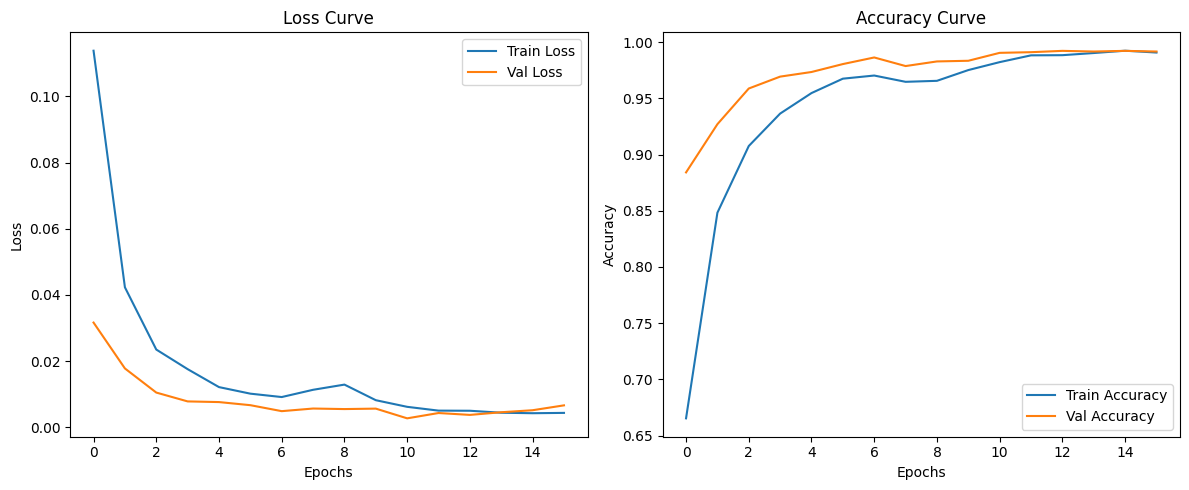

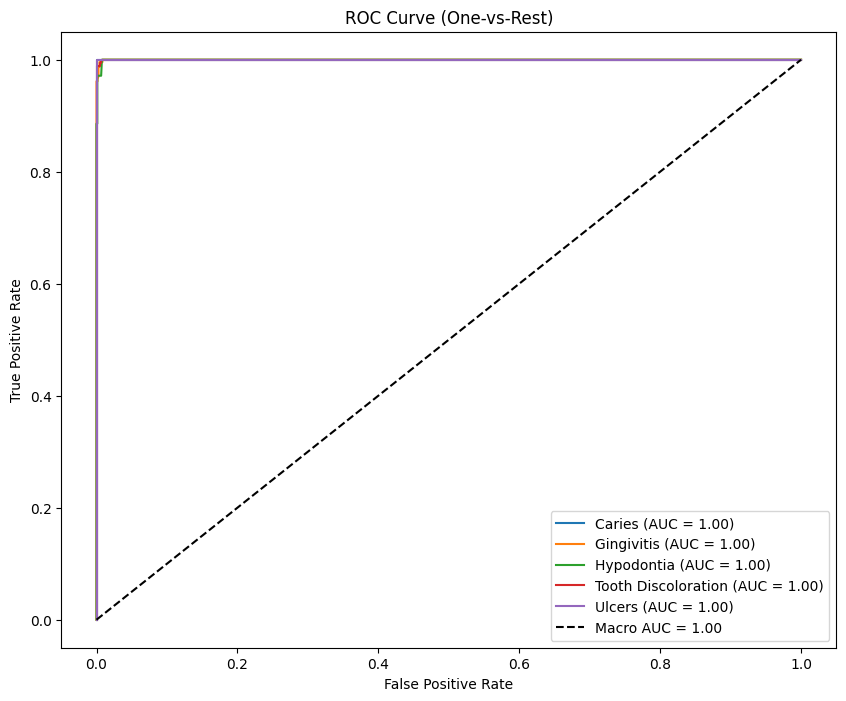

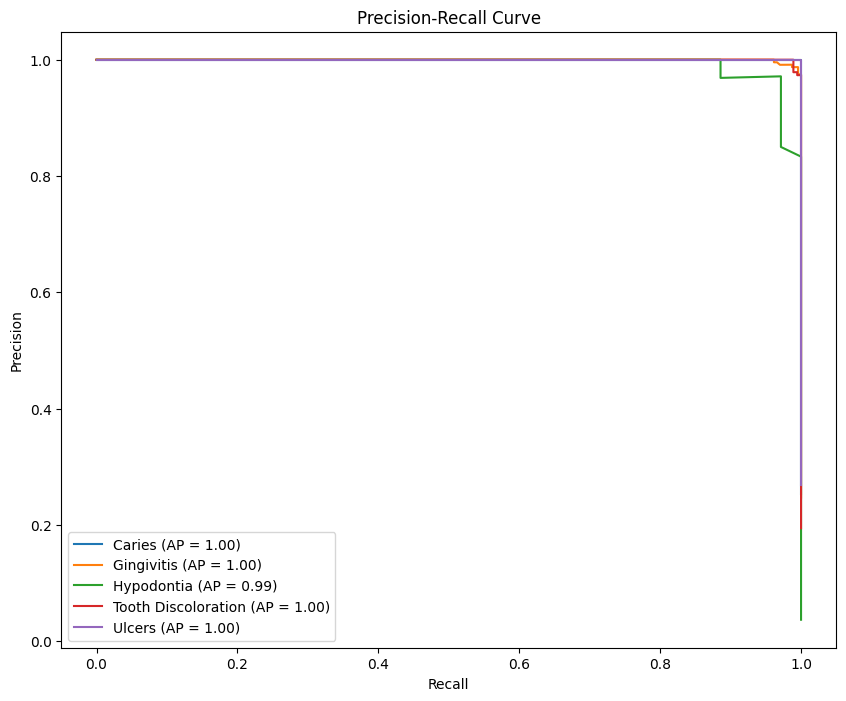

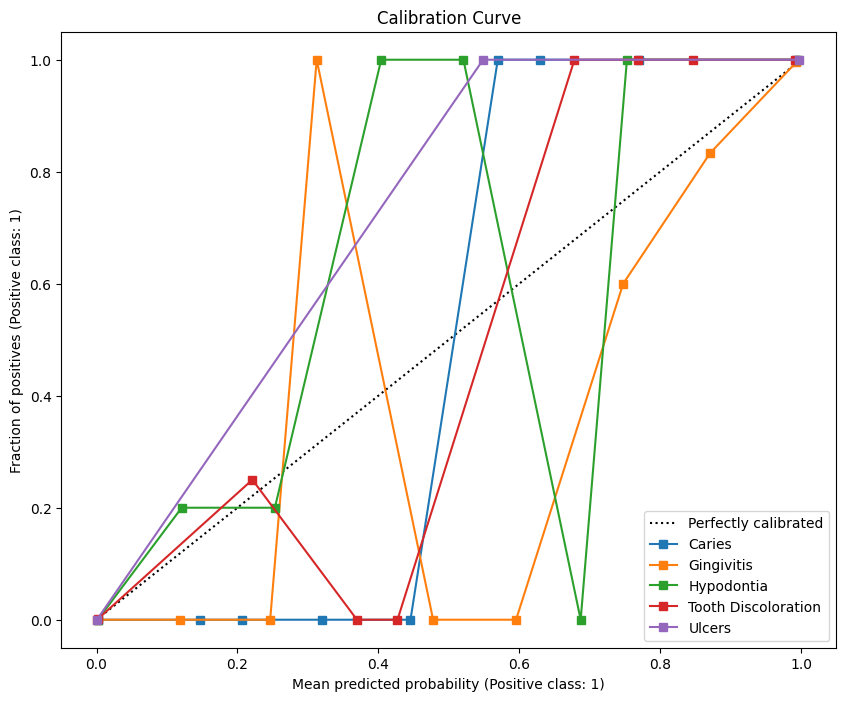

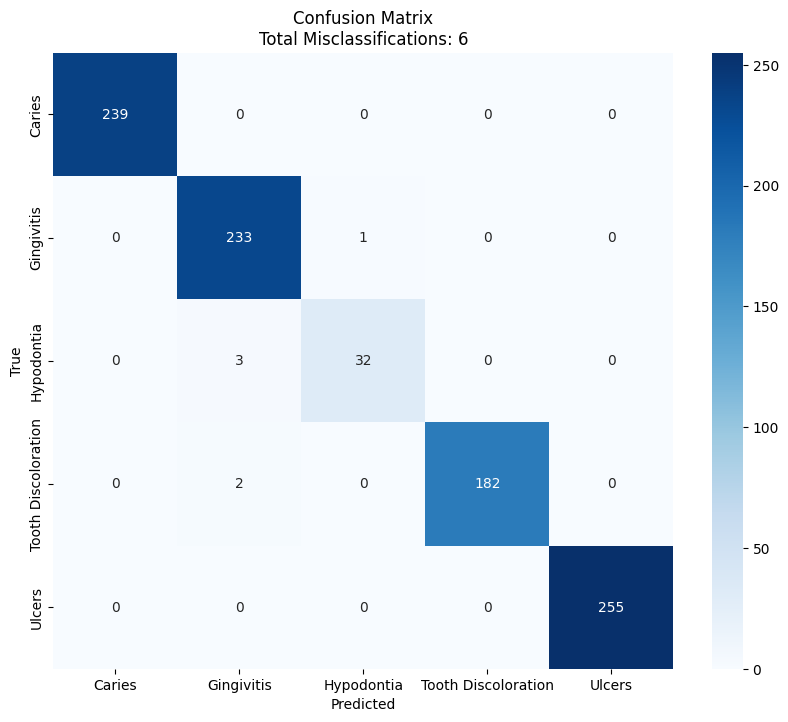

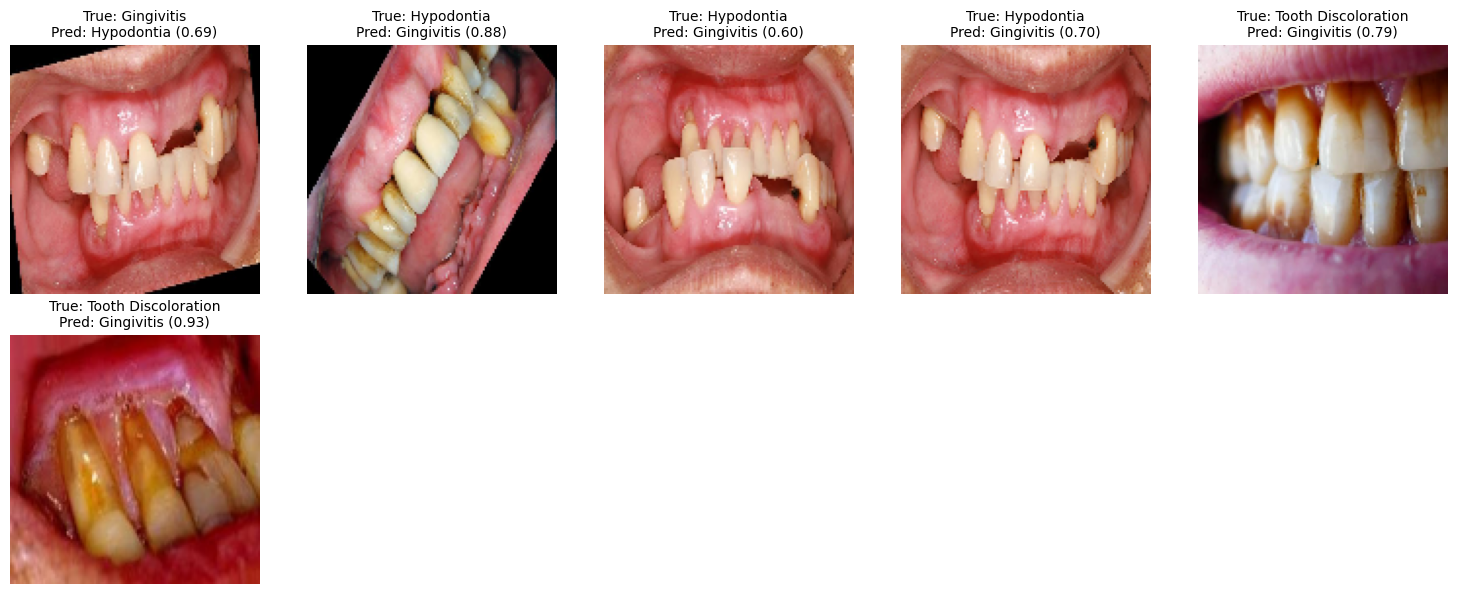

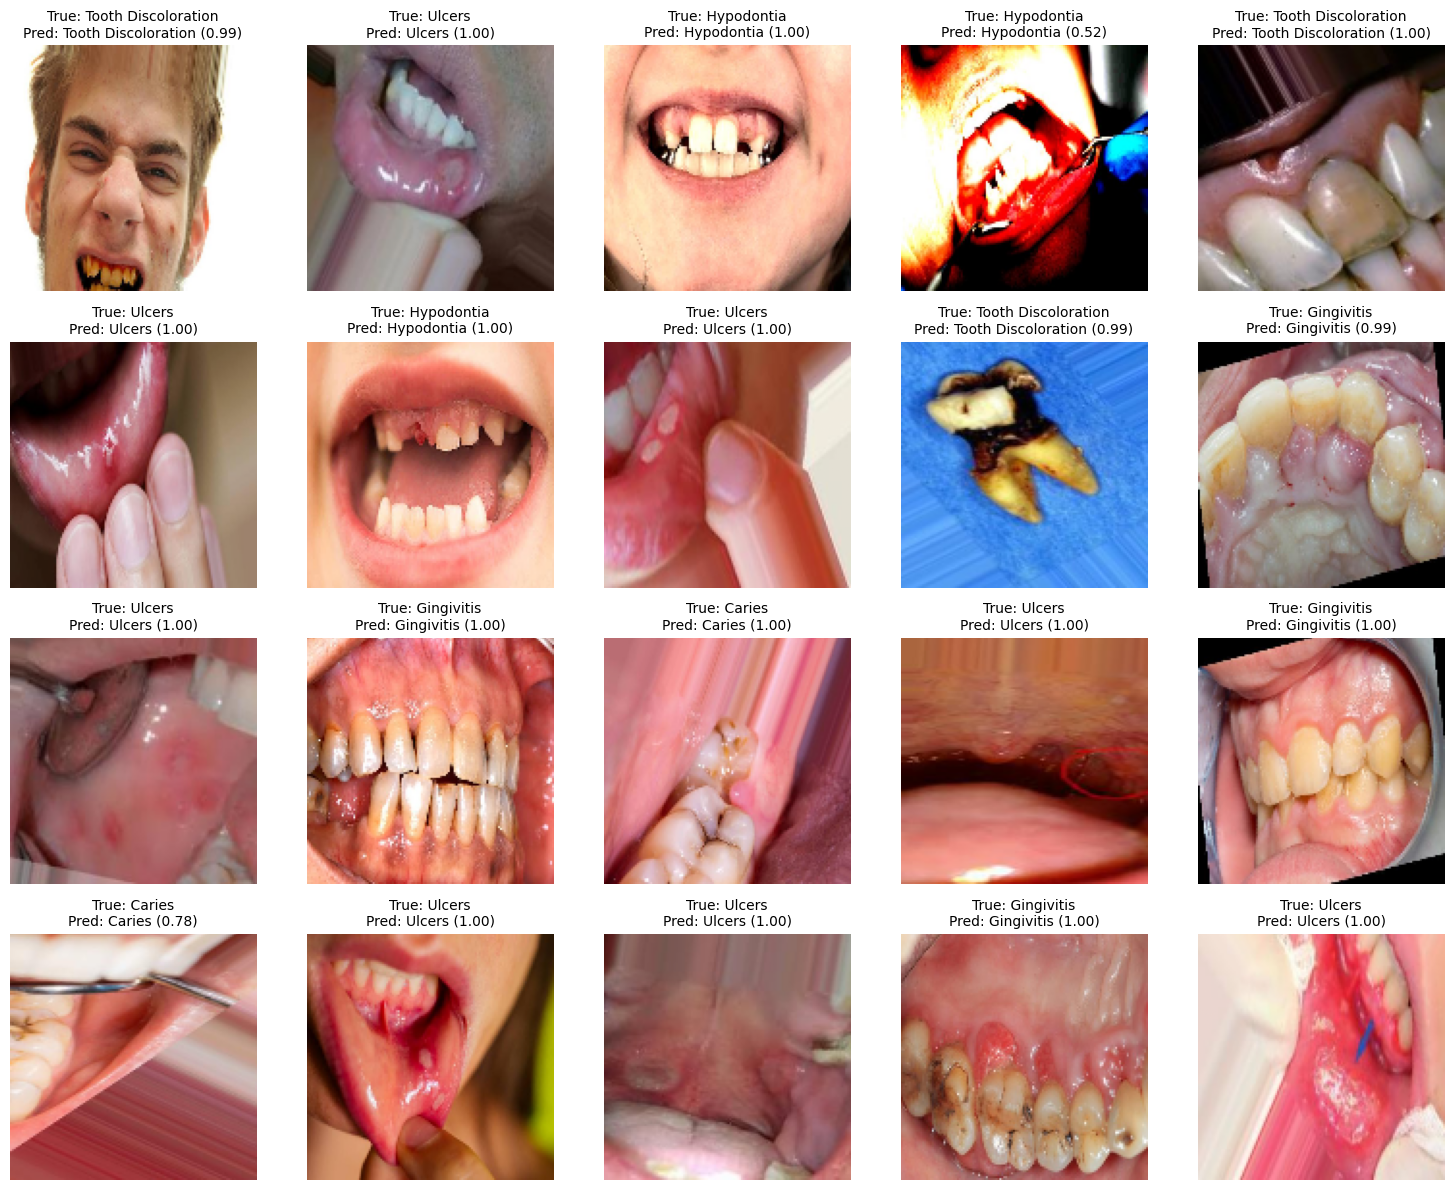

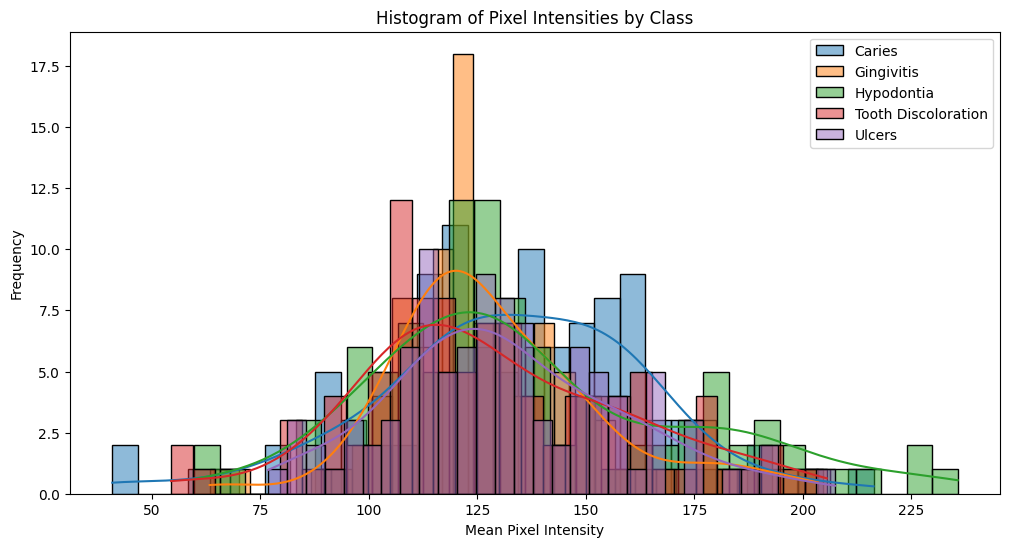

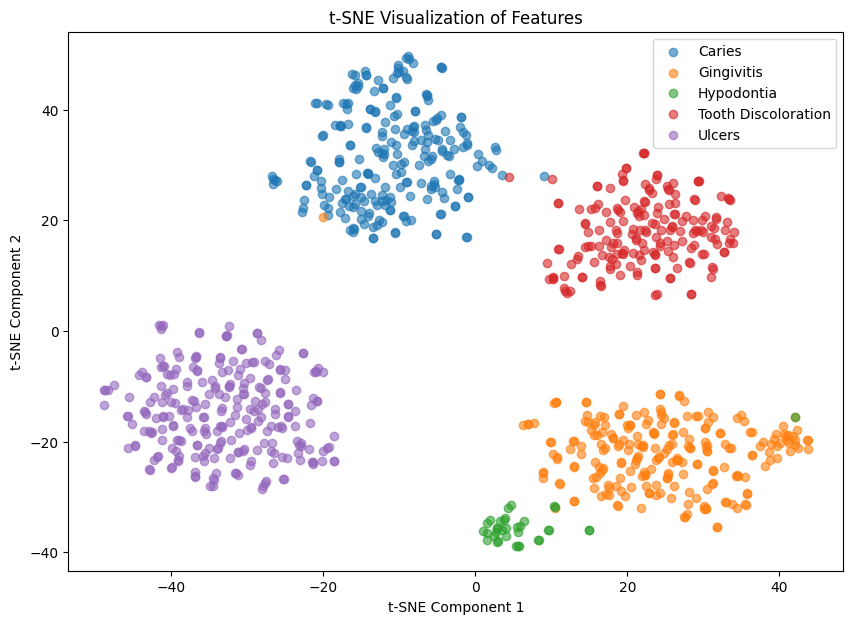


=== Evaluation Summary ===
Accuracy: 0.9937
Precision: 0.9937
Recall: 0.9937
F1-Score: 0.9936
Cohen's Kappa: 0.9917
MCC: 0.9917
Log Loss: 0.0230

=== Classification Report ===
                     precision    recall  f1-score   support

             Caries       1.00      1.00      1.00       239
         Gingivitis       0.98      1.00      0.99       234
         Hypodontia       0.97      0.91      0.94        35
Tooth Discoloration       1.00      0.99      0.99       184
             Ulcers       1.00      1.00      1.00       255

           accuracy                           0.99       947
          macro avg       0.99      0.98      0.98       947
       weighted avg       0.99      0.99      0.99       947



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, precision_recall_curve, cohen_kappa_score, matthews_corrcoef,
    accuracy_score, classification_report, log_loss, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency
from sklearn.utils import resample
import seaborn as sns
import random

# ### Global Variables
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 5
classes = ['Caries', 'Gingivitis', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']
n_classes = len(classes)

# ### Dataset & Transforms
class MedicalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = [cls for cls in os.listdir(data_dir) if cls in classes]
        self.classes = sorted(self.classes, key=lambda x: classes.index(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = self._make_dataset()

    def _make_dataset(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    samples.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

train_transform = A.Compose([
    A.Resize(128, 128),
    A.Rotate(limit=15),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.CLAHE(clip_limit=2.0),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ### Model Architecture
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x

class MultiDentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.features = nn.Sequential(
            base.features.conv0,
            base.features.norm0,
            base.features.relu0,
            base.features.pool0,
            base.features.denseblock1,
            base.features.transition1,
            SelfAttention(128),
            base.features.denseblock2,
            base.features.transition2,
            SelfAttention(256),
            base.features.denseblock3,
            base.features.transition3,
            SelfAttention(512),
            base.features.denseblock4,
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        flattened = features.view(features.size(0), -1)
        return self.classifier(flattened)

# ### Loss & Metrics
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# ### Evaluation Utilities
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image_tensor * std + mean
    image = image.clamp(0, 1)
    return image.permute(1, 2, 0).numpy()

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    labels_list = []
    preds_list = []
    probs_list = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            labels_list.extend(labels.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            probabilities = torch.softmax(outputs, dim=1)
            probs_list.extend(probabilities.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_correct / len(loader.dataset)
    return epoch_loss, epoch_acc, np.array(labels_list), np.array(preds_list), None, np.array(probs_list)

def extract_features(model, loader, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            feats = model.features(inputs)
            feats = feats.view(feats.size(0), -1)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# ### Visualization Functions
def plot_roc(test_true, test_probs):
    plt.figure(figsize=(10, 8))
    y_bin = label_binarize(test_true, classes=np.arange(n_classes))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], test_probs[:, i])
        roc_auc = roc_auc_score(y_bin[:, i], test_probs[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    macro_auc = roc_auc_score(y_bin, test_probs, multi_class="ovo", average="macro")
    plt.plot([0, 1], [0, 1], 'k--', label=f'Macro AUC = {macro_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend()
    plt.show()

def plot_prc(test_true, test_probs):
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(test_true == i, test_probs[:, i])
        ap = average_precision_score(test_true == i, test_probs[:, i])
        plt.plot(recall, precision, label=f'{classes[i]} (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def plot_calibration(test_true, test_probs):
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        from sklearn.calibration import CalibrationDisplay
        CalibrationDisplay.from_predictions(
            (test_true == i).astype(int),
            test_probs[:, i],
            n_bins=10,
            name=classes[i],
            ax=plt.gca()
        )
    plt.title('Calibration Curve')
    plt.show()

def plot_cm(test_true, test_preds):
    cm = confusion_matrix(test_true, test_preds)
    total_errors = np.sum(cm) - np.trace(cm)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix\nTotal Misclassifications: {total_errors}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ### Function to Plot All Misclassified Images
def plot_misclassified_images(test_dataset, test_true, test_preds, test_probs, classes, num_cols=5):
    misclassified_idx = np.where(test_true != test_preds)[0]
    num_misclassified = len(misclassified_idx)
    if num_misclassified == 0:
        print("No misclassified samples to display.")
        return

    num_rows = (num_misclassified + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 3 * num_rows))
    for i, idx in enumerate(misclassified_idx):
        image_tensor, _ = test_dataset[idx]
        image = denormalize(image_tensor)
        true_label = test_true[idx]
        pred_label = test_preds[idx]
        confidence = test_probs[idx, pred_label]
        true_class = classes[true_label]
        pred_class = classes[pred_label]

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_class}\nPred: {pred_class} ({confidence:.2f})", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('misclassified_images.png')
    plt.show()

# ### Function to Plot n Correctly Classified Images
def plot_correctly_classified_images(test_dataset, test_true, test_preds, test_probs, classes, n=20, num_cols=5):
    correctly_classified_idx = np.where(test_true == test_preds)[0]
    if len(correctly_classified_idx) < n:
        print(f"Only {len(correctly_classified_idx)} correctly classified samples available. Adjusting n.")
        n = len(correctly_classified_idx)

    selected_idx = random.sample(list(correctly_classified_idx), n)
    num_rows = (n + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 3 * num_rows))
    for i, idx in enumerate(selected_idx):
        image_tensor, _ = test_dataset[idx]
        image = denormalize(image_tensor)
        true_label = test_true[idx]
        pred_label = test_preds[idx]
        confidence = test_probs[idx, pred_label]
        true_class = classes[true_label]
        pred_class = classes[pred_label]

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_class}\nPred: {pred_class} ({confidence:.2f})", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('correctly_classified_images.png')
    plt.show()

# ### Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# ### Main Training and Evaluation Loop
def main():
    # ---- Data Setup ----
    base_dir = '/kaggle/working/dataset'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    os.makedirs('/content/gdrive/MyDrive/MedicalPaper', exist_ok=True)

    train_dataset = MedicalDataset(train_dir, transform=train_transform)
    val_dataset = MedicalDataset(val_dir, transform=val_transform)
    test_dataset = MedicalDataset(test_dir, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # ---- Model Setup ----
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultiDentNet(num_classes=n_classes).to(device)

    # ---- Training Components ----
    criterion = FocalLoss()
    optimizer = optim.AdamW([
        {'params': model.features.parameters(), 'lr': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 5e-4}
    ], weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=2)
    scaler = GradScaler()

    early_stopping = EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE,
        verbose=True,
        path='/content/gdrive/MyDrive/MedicalPaper/best_model.pth'
    )

    # ---- Training Loop ----
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            clip_gradients(model)
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()

        train_epoch_loss = running_loss / len(train_dataset)
        train_epoch_acc = running_correct / len(train_dataset)
        train_loss_history.append(train_epoch_loss)
        train_acc_history.append(train_epoch_acc)

        val_epoch_loss, val_epoch_acc, _, _, _, _ = validate_epoch(model, val_loader, criterion, device)
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc)

        print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
              f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.2%} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.2%}")

        scheduler.step(val_epoch_loss)
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # ---- Final Evaluation ----
    print("\nTraining complete. Loading best model for evaluation...")
    model.load_state_dict(torch.load('/content/gdrive/MyDrive/MedicalPaper/best_model.pth', map_location=device))
    test_loss, test_acc, test_true, test_preds, _, test_probs = validate_epoch(model, test_loader, criterion, device)

    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}")

    # ---- Learning Curves ----
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

    # ---- Visualizations ----
    plot_roc(test_true, test_probs)
    plot_prc(test_true, test_probs)
    plot_calibration(test_true, test_probs)
    plot_cm(test_true, test_preds)

    # ---- Plot All Misclassified Images ----
    plot_misclassified_images(test_dataset, test_true, test_preds, test_probs, classes)

    # ---- Plot n=20 Correctly Classified Images ----
    plot_correctly_classified_images(test_dataset, test_true, test_preds, test_probs, classes, n=20)

    # ---- Additional Visualizations ----
    plt.figure(figsize=(12, 6))
    for i, cls in enumerate(classes):
        class_images = [img_path for img_path, label in train_dataset.samples
                        if label == train_dataset.class_to_idx[cls]]
        if class_images:
            intensities = [np.mean(np.array(Image.open(img).convert('L'))) for img in class_images[:100]]
            sns.histplot(intensities, bins=30, kde=True, label=cls)
    plt.title('Histogram of Pixel Intensities by Class')
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    features, test_labels = extract_features(model, test_loader, device)
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    plt.figure(figsize=(10, 7))
    for i, cls in enumerate(classes):
        plt.scatter(features_2d[test_labels == i, 0], features_2d[test_labels == i, 1],
                    label=cls, alpha=0.6)
    plt.title('t-SNE Visualization of Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

    # ---- Metrics ----
    accuracy_val = accuracy_score(test_true, test_preds)
    precision_val = precision_score(test_true, test_preds, average='weighted')
    recall_val = recall_score(test_true, test_preds, average='weighted')
    f1_val = f1_score(test_true, test_preds, average='weighted')
    kappa = cohen_kappa_score(test_true, test_preds)
    mcc = matthews_corrcoef(test_true, test_preds)
    logloss = log_loss(test_true, test_probs)

    print("\n=== Evaluation Summary ===")
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print("\n=== Classification Report ===")
    print(classification_report(test_true, test_preds, target_names=classes))

if __name__ == "__main__":
    main()

# Visualization of the model

In [ ]:
pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [16]:
pip install torchinfo

In [ ]:
from torchinfo import summary
import torch
import torch.nn as nn

# Define your model (replace ExampleModel with your actual model class)
class MultiDentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.features = nn.Sequential(
            base.features.conv0,
            base.features.norm0,
            base.features.relu0,
            base.features.pool0,
            base.features.denseblock1,
            base.features.transition1,
            SelfAttention(128),
            base.features.denseblock2,
            base.features.transition2,
            SelfAttention(256),
            base.features.denseblock3,
            base.features.transition3,
            SelfAttention(512),
            base.features.denseblock4,
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        flattened = features.view(features.size(0), -1)
        return self.classifier(flattened)

# Initialize the model
num_classes = 5 # Set this to the number of classes in your dataset
model = MultiDentNet(num_classes)

# Print the model summary
summary(model, input_size=(1, 3, 128, 128))  # Adjust input_size to match your model's expected input


Layer (type:depth-idx)                   Output Shape              Param #
CustomDenseNet                           [1, 5]                    --
├─Sequential: 1-1                        [1, 1024, 1, 1]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           128
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                    [1, 64, 32, 32]           --
│    └─_DenseBlock: 2-5                  [1, 256, 32, 32]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 32, 32]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 32, 32]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 32, 32]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 32, 32]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 32, 32]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 32, 32]     

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
from torchinfo import summary  # Use torchinfo instead of torchsummary

# Define the SelfAttention module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x

# Define the MultiDentNet model
class MultiDentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.features = nn.Sequential(
            base.features.conv0,
            base.features.norm0,
            base.features.relu0,
            base.features.pool0,
            base.features.denseblock1,
            base.features.transition1,
            SelfAttention(128),
            base.features.denseblock2,
            base.features.transition2,
            SelfAttention(256),
            base.features.denseblock3,
            base.features.transition3,
            SelfAttention(512),
            base.features.denseblock4,
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        return self.classifier(features.view(features.size(0), -1))

# Initialize the model
num_classes = 5  # Set this to the number of classes in your dataset
model = MultiDentNet(num_classes)

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model summary using torchinfo
summary(model, input_size=(1, 3, 128, 128), device=device.type)



Layer (type:depth-idx)                   Output Shape              Param #
CustomDenseNet                           [1, 6]                    --
├─Sequential: 1-1                        [1, 1024, 1, 1]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           128
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                    [1, 64, 32, 32]           --
│    └─_DenseBlock: 2-5                  [1, 256, 32, 32]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 32, 32]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 32, 32]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 32, 32]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 32, 32]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 32, 32]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 32, 32]     

In [ ]:
pip install torchview

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
from torchview import draw_graph

# Define your model (replace CustomDenseNet with your actual model class)
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x

class MultiDentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.features = nn.Sequential(
            base.features.conv0,
            base.features.norm0,
            base.features.relu0,
            base.features.pool0,
            base.features.denseblock1,
            base.features.transition1,
            SelfAttention(128),
            base.features.denseblock2,
            base.features.transition2,
            SelfAttention(256),
            base.features.denseblock3,
            base.features.transition3,
            SelfAttention(512),
            base.features.denseblock4,
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        return self.classifier(features.view(features.size(0), -1))

# Initialize the model
num_classes = 5  # Set this to the number of classes in your dataset
model = MultiDentNet(num_classes)

# Create a sample input tensor
sample_input = torch.randn(1, 3, 128, 128)  # Adjust the size to match your model's expected input

# Visualize the model graph
model_graph = draw_graph(model, input_data=sample_input, device='cpu', save_graph=True, filename="model_graph.png")
